In [346]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from tensorflow import keras
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [347]:
file = pd.read_json("data.json")
data = pd.DataFrame(file['MSFT']['chart'])
data.set_index('date',inplace = True)
data = data.filter(['close'])
data_len = len(data.values)
feature = 1

In [348]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.values)
test_size = 360 
window = 14

train_data = scaled_data[0:data_len-test_size-window,:]
x_train = []
y_train = []

for i in range(window, len(train_data)): 
  x_train.append(train_data[i-window:i, :])
  y_train.append(train_data[i, :])
  
x_train, y_train = np.array(x_train), np.array(y_train)
test_data = scaled_data[data_len-(window+test_size):data_len,:]
x_test = []
y_test = []
for i in range(window, len(test_data)):
  x_test.append(test_data[i-window:i, :])
  y_test.append(test_data[i, :])

x_test,y_test = np.array(x_test), np.array(y_test)

In [349]:
learning_rate = 0.03
input_model = Input(shape=(window, feature))
dropout_layer = Dropout(0.2)
Dense_window = Dense(window)
Dense_feature = Dense(1)
LSTM_MODEL = Bidirectional(LSTM(30,activation='tanh'))
output_layer1 = LSTM_MODEL(input_model)
output_layer2 = dropout_layer(output_layer1)
output_layer3 = Dense_window(output_layer2 )
output = Dense_feature(output_layer3)
model = Model(input_model,output)

model.summary()
model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Model: "model_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 14, 1)]           0         
                                                                 
 bidirectional_32 (Bidirecti  (None, 60)               7680      
 onal)                                                           
                                                                 
 dropout_51 (Dropout)        (None, 60)                0         
                                                                 
 dense_102 (Dense)           (None, 14)                854       
                                                                 
 dense_103 (Dense)           (None, 1)                 15        
                                                                 
Total params: 8,549
Trainable params: 8,549
Non-trainable params: 0
________________________________________________________

In [350]:
predictions = model.predict(x_test)
print('r2_score: ',r2_score(y_test, predictions))
print('MAPE: ',mean_absolute_percentage_error(y_test, predictions))
print('MAE: ', mean_absolute_error(y_test, predictions))
print('MSE: ', mean_squared_error(y_test, predictions,squared=True))
print('rmse: ',mean_squared_error(y_test, predictions,squared=False))

12/12 [==============================] - 0s 1ms/step
r2_score:  0.9502145536768526
MAPE:  0.06047780488762022
MAE:  0.07016210660368533
MSE:  0.007108363815390457
rmse:  0.0843111132377604


C:\Users\lawre\AppData\Local\Temp\ipykernel_7728\2626133672.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


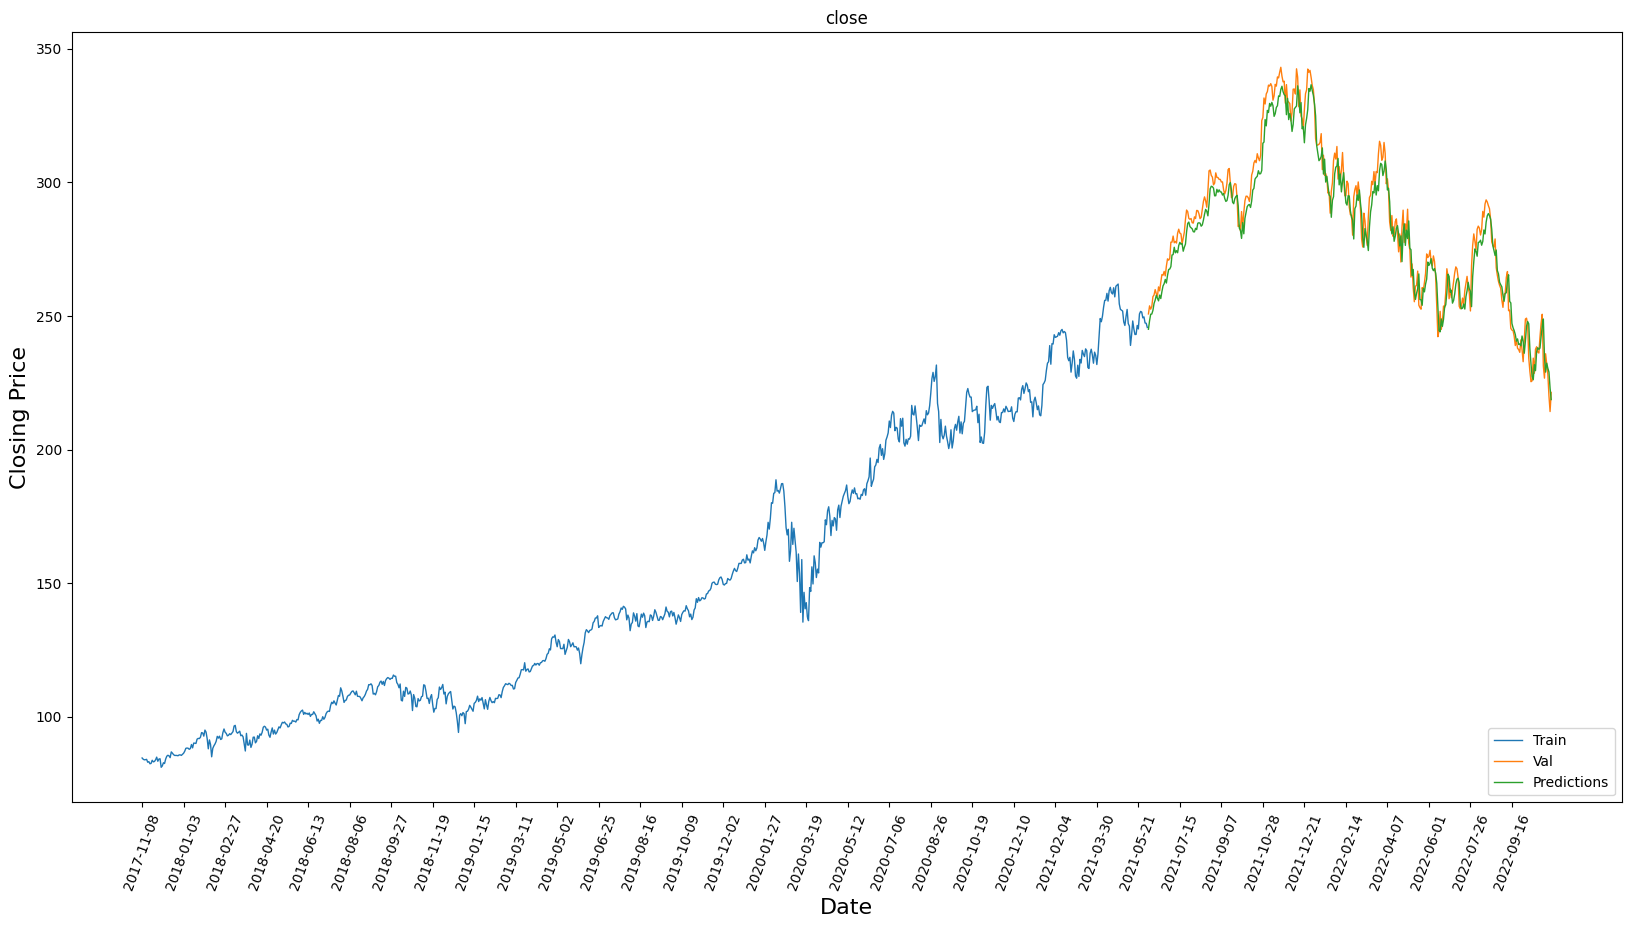

In [351]:
predictions = scaler.inverse_transform(predictions)
train = data[:data_len-test_size]
test = data[data_len-test_size:data_len]
test['Predictions'] = predictions
plt.figure(figsize=(20,10))
plt.title('close')
plt.xlabel('Date', fontsize = 16 )
plt.ylabel('Closing Price', fontsize = 16 )
plt.plot(train['close'],linewidth=1)
plt.plot(test[['close','Predictions']],linewidth=1)
plt.xticks(np.arange(0, len(data.values)+1,37),rotation=70)
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

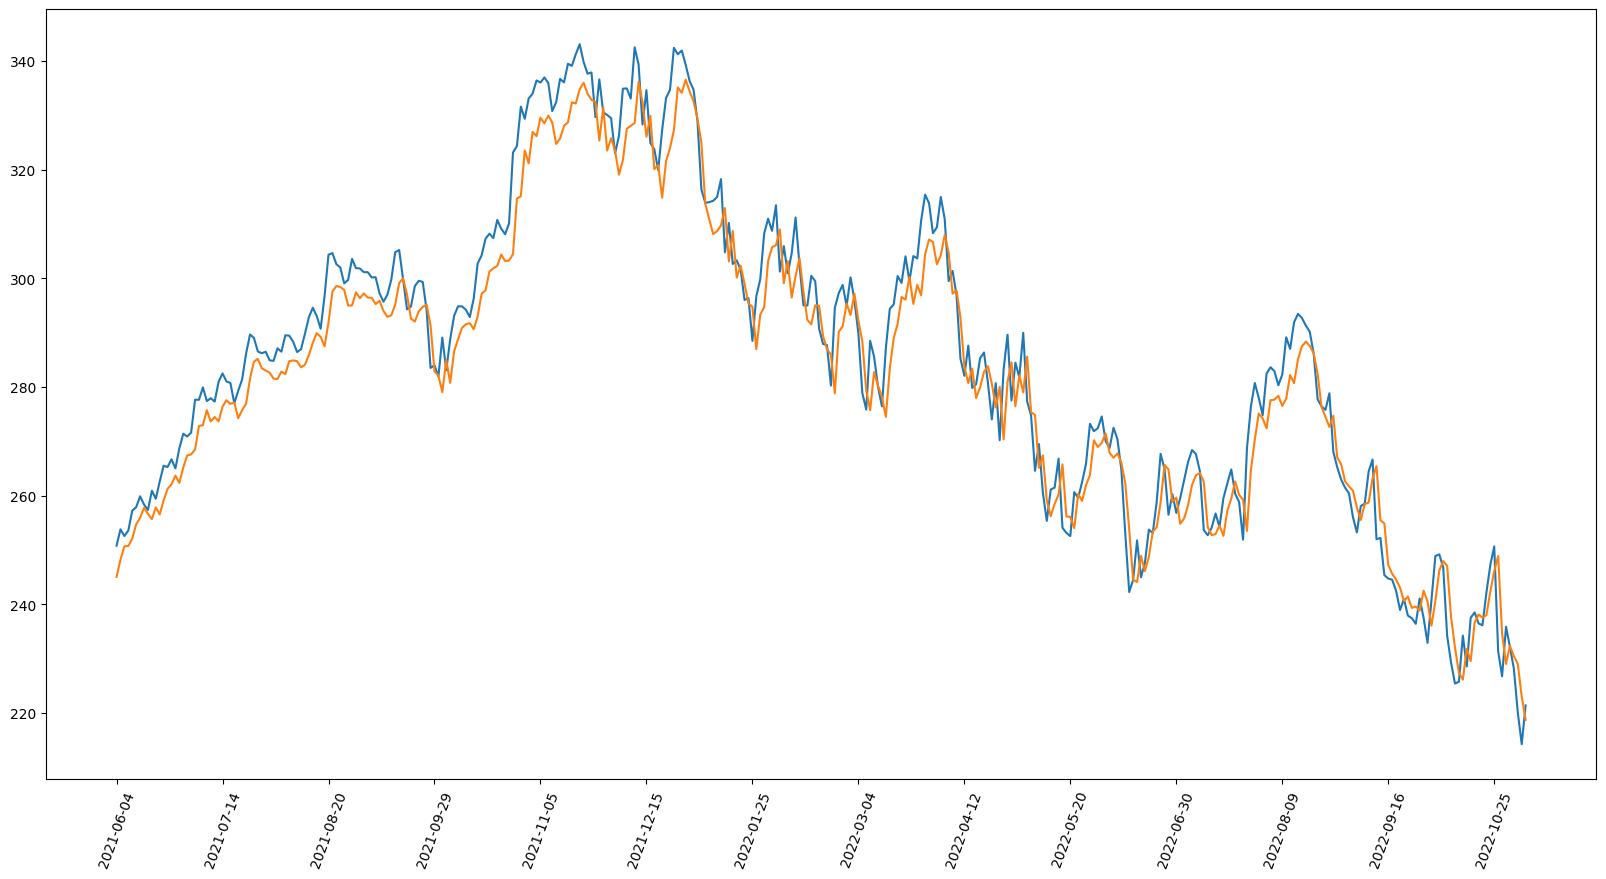

In [352]:
plt.figure(figsize=(20,10))
plt.xticks(np.arange(0, len(test)+1,27),rotation=70)
plt.plot(test[['close','Predictions']],linewidth=1.5)